# NESS Short Course
## Introduction to the analysis of neural electrophysiology data
### Saturday, June 3, 2023
---
### Spike-field coherence

---
If you're running this on **Google Colab**, then uncomment and run the next two cells.

In [ ]:
# !git clone https://github.com/Mark-Kramer/NESS-Short-Course-2023.git

In [ ]:
# import sys
# sys.path.insert(0,'/content/NESS-Short-Course-2023')

## Load the data and look at it.

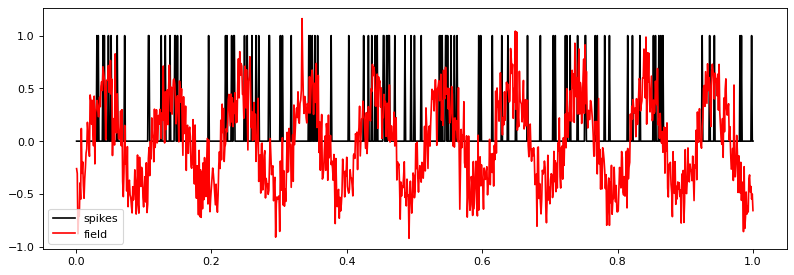

In [18]:
# Load modules we'll need.

import scipy.io as io
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt

# Load the data and plot it.

data = io.loadmat('NESS-Spike-field-coherence-1.mat')  # Load the multiscale data,
y = data['y']                                # ... get the LFP data,
n = data['n']                                # ... get the spike data,
t = data['t'].reshape(-1)                    # ... get the time axis,
K = np.shape(n)[0]                           # Get the number of trials,
N = np.shape(n)[1]                           # ... and the number of data points in each trial,
dt = t[1]-t[0]                               # Get the sampling interval.

f = plt.figure(figsize=(12, 4), dpi=80)
plt.plot(t, n[0,:], 'k')
plt.plot(t, y[0,:], 'r');
plt.legend(['spikes', 'field']);

***

# Dependence on rate (Part 1)

### For convenience, make a function to compute the cohernece.

In [19]:
def coherence(n,y,t):                           #INPUT (spikes, fields, time)
    K = np.shape(n)[0]                          #... where spikes and fields are arrays [trials, time]
    N = np.shape(n)[1]
    T = t[-1]
    SYY = np.zeros(int(N/2+1))
    SNN = np.zeros(int(N/2+1))
    SYN = np.zeros(int(N/2+1), dtype=complex)
    
    for k in np.arange(K):
        yf = np.fft.rfft((y[k,:]-np.mean(y[k,:])) *np.hanning(N))    # Hanning taper the field,
        nf = np.fft.rfft((n[k,:]-np.mean(n[k,:])))                   # ... but do not taper the spikes.
        SYY = SYY + ( np.real( yf*np.conj(yf) ) )/K                  # Field spectrum
        SNN = SNN + ( np.real( nf*np.conj(nf) ) )/K                  # Spike spectrum
        SYN = SYN + (          yf*np.conj(nf)   )/K                  # Cross spectrum

    cohr = np.abs(SYN) / np.sqrt(SYY) / np.sqrt(SNN)                 # Coherence
    f = np.fft.rfftfreq(N, dt)                                       # Frequency axis for plotting
    
    return (cohr, f, SYY, SNN, SYN)

Let's try it:

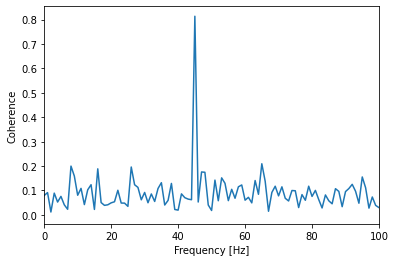

In [20]:
[cohr, f, SYY, SNN, SYN] = coherence(n,y,t)
plt.plot(f,cohr)
plt.xlim([0, 100]); plt.xlabel('Frequency [Hz]'); plt.ylabel('Coherence');

### Make a function to thin a spike train.

In [21]:
def thinned_spike_train(n, thinning_factor):              # Thin the spike train (n) by the thinning_factor.
    n_thinned = np.copy(n)                                # Make a copy of the spike train data.
    for k in np.arange(K):                                # For each trial,
        spike_times = np.where(n[k,:]==1)                 # ...find the spikes.
        n_spikes = np.size(spike_times)                   # ...determine number of spikes.
        spike_times_random = spike_times[0][np.random.permutation(n_spikes)]    # ...permute spikes indices,
        n_remove=int(np.floor(thinning_factor*n_spikes))  # ... determine number of spikes to remove,
        n_thinned[k,spike_times_random[1:n_remove]]=0     # remove the spikes.
    return n_thinned

Let's try it:

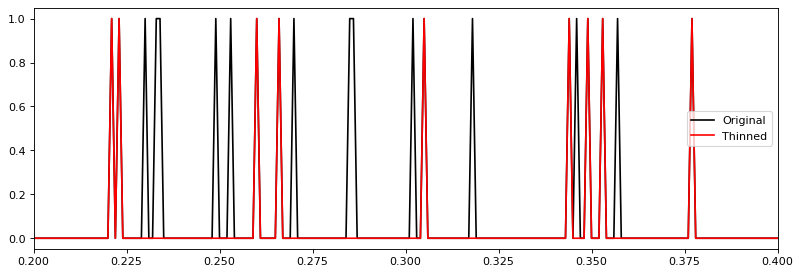

In [22]:
f = plt.figure(figsize=(12, 4), dpi=80)
plt.plot(t, n[0,:], 'k')
plt.plot(t, thinned_spike_train(n,0.5)[0,:], 'r');
plt.xlim([0.2, 0.4])
plt.legend(['Original', 'Thinned']);

### Compare the spike-field coherence for original and thinned data.

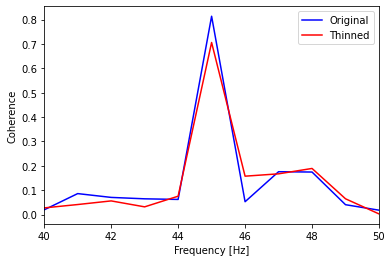

In [23]:
[cohr, f, SYY, SNN, SYN] = coherence(n,y,t)                          # Coherence for original spike train.
plt.clf()
plt.plot(f,cohr, 'b')
[cohr, f, SYY, SNN, SYN] = coherence(thinned_spike_train(n,0.5),y,t) # ... and for the thinned spike train.
plt.plot(f,cohr, 'r')
plt.xlim([40, 50])
plt.legend(['Original', 'Thinned'])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence');

### Repeat for different thinning factors.

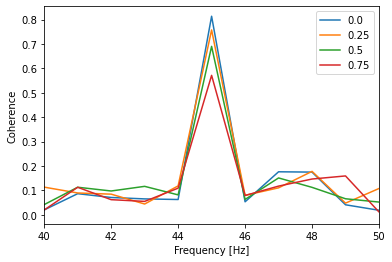

In [36]:
plt.figure(1); plt.clf();
counter=1
for thinner in np.arange(0,1,0.25):
    thinned = thinned_spike_train(n,thinner)
    [cohr, f, SYY, SNN, SYN] = coherence(thinned,y,t) # ... and for the thinned spike train.
    plt.figure(1);
    plt.plot(f,cohr,label=str(thinner))

plt.figure(1);
plt.xlim([40, 50]);
plt.legend();
plt.xlabel('Frequency [Hz]');
plt.ylabel('Coherence');